Dataset: https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data

### import pacakges

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_profiling
from sklearn.cluster import KMeans

### import dataset

In [2]:
# read data
portfolio = pd.read_json('portfolio.json', lines=True)
profile = pd.read_json('profile.json', lines=True)
transcript = pd.read_json('transcript.json', lines=True)

In [3]:
# Note: we only have 10 offer types in the dataset

portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### summary statistics

**From the age distribution, we can see the 25% quantile is 45, and the maximum age is 118. The assumption is to protect user privacy, Starbucks makes modifications to the age data and we cannot revert back the data; thus, we drop the age part in our analysis.**


In [6]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

**To calculate duration of membership for each user, we use the latest date in the datast minus became_number_on.**

In [7]:
# convert the string to datetime
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

# calculate membership duration 
profile['duration'] = profile['became_member_on'].max() - profile['became_member_on']

# conver the duration to days
profile['duration'] = profile['duration'].apply(lambda x: x.days)

In [8]:
profile.head()

,gender,age,id,became_member_on,income,duration
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356


**Drop all unknown gender (including "O") and NaN income values**

In [9]:
# drop unknown gender and fill nan
profile = profile.dropna().reset_index(drop=True)

# get the final profile dataframe
profile = profile[['id', 'gender', 'income', 'duration']]

### modify transcript

**For k-means clustering, count frequency of events as input on the user level.**

In [10]:
# for k-means clustering, count frequency of events as input on the user level
transcript_summary = transcript.groupby(['person','event']).count().reset_index()

transcript_summary.head()

,person,event,value,time
0,0009655768c64bdeb2e877511632db8f,offer completed,3,3
1,0009655768c64bdeb2e877511632db8f,offer received,5,5
2,0009655768c64bdeb2e877511632db8f,offer viewed,4,4
3,0009655768c64bdeb2e877511632db8f,transaction,8,8
4,00116118485d4dfda04fdbaba9a87b5c,offer received,2,2


In [11]:
# pivote the table
transcript_pivot = transcript_summary.pivot(index='person', columns='event', values='value').reset_index().fillna(0)

transcript_pivot.head()

event,person,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,2.0,2.0,3.0
2,0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0
4,0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0


**For the outcome variables, construct the completion rate for each offer type.**

In [12]:
# value — (dict of strings) — either an offer id or transaction amount depending on the record
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])

transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,1.59,714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,9.53,714
306531,a00058cf10334a308c68e7631c529907,transaction,3.61,714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,3.53,714


**Get the total transaction amount for each user.**

In [13]:
# sum the total transactions (if event == transaction)
transcript_transaction = transcript[transcript['event']=='transaction'].groupby(['person'])['value'].sum().reset_index()

transcript_transaction.head()

,person,value
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


In [14]:
# get the final input data for k-means clustering
transcript_input = pd.merge(transcript_pivot, transcript_transaction, how='left', on='person').fillna(0)

transcript_input.head()

,person,offer completed,offer received,offer viewed,transaction,value
0,0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,127.60
1,00116118485d4dfda04fdbaba9a87b5c,0.0,2.0,2.0,3.0,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0,79.46
3,0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0,154.05


### Construct outcome variables (completion status for each offer on user level)

In [15]:
# exclude transactions 
transcript_offer = transcript[transcript['event'] != 'transaction'].reset_index()

# aggregate the data on user id, event type and user action level
transcript_offer = transcript_offer.groupby(by=['person','event','value']).count().reset_index()

# get the completion data for each offer type on the user level
transcript_offer_completion = pd.merge(transcript_offer[transcript_offer['event']=='offer received'],
                                       transcript_offer[transcript_offer['event']=='offer completed'],
                                       how='left',
                                       on = ['person','value'])

# fill nan values with 0 (when a user receives an offer but doesn't complete)
transcript_offer_completion = transcript_offer_completion.fillna(0)

transcript_offer_completion.head()

,person,event_x,value,index_x,time_x,event_y,index_y,time_y
0,0009655768c64bdeb2e877511632db8f,offer received,2906b810c7d4411798c6938adc9daaa5,1,1,offer completed,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,offer received,3f207df678b143eea3cee63160fa8bed,1,1,0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,offer received,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,offer received,f19421c1d4aa40978ebb69ca19b0e20d,1,1,offer completed,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,offer received,fafdcd668e3743c1bb461111dcafc2a4,1,1,offer completed,1.0,1.0


In [16]:
# calculate the offer completion rate
transcript_offer_completion['completion rate'] = transcript_offer_completion['index_y']/transcript_offer_completion['index_x']

# get the final dataframe
transcript_offer_completion = transcript_offer_completion[['person', 'value', 'completion rate']]

# pivot the table (column = offer id, row = user id)
transcript_offer_completion = transcript_offer_completion.pivot(index='person', columns='value', values='completion rate').reset_index()

transcript_offer_completion.head()

value,person,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN
3,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,NaN,1.0
4,0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN,1.0,NaN


### k-means clustering

In [17]:
# construct input dataframe
df_input = pd.merge(profile, transcript_input, how='left', left_on='id', right_on='person').drop(columns='person')

# 1 = female, 0 = male
df_input['gender'] = df_input['gender'].apply(lambda x: 1 if x == 'F' else 0)

# reorder columns 
X = df_input[['gender', 'income', 'duration', 'offer received', 'offer viewed', 'offer completed', 'transaction', 'value']]

In [18]:
X

,gender,income,duration,offer received,offer viewed,offer completed,transaction,value
0,1,112000.0,376,2.0,0.0,1.0,3.0,77.01
1,1,100000.0,443,4.0,4.0,3.0,7.0,159.27
2,0,70000.0,91,4.0,3.0,2.0,3.0,57.73
3,0,53000.0,167,6.0,6.0,5.0,3.0,36.43
4,0,51000.0,257,3.0,2.0,1.0,4.0,15.62
...,...,...,...,...,...,...,...,...
14820,1,54000.0,52,3.0,3.0,0.0,7.0,20.03
14821,0,72000.0,13,3.0,1.0,1.0,7.0,25.97
14822,0,73000.0,546,3.0,1.0,0.0,8.0,39.74
14823,1,50000.0,871,3.0,3.0,3.0,14.0,189.67


**Standardize the data.**

In [19]:
# standardize
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)

In [20]:
# kmeans clustering

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}


# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_std)
    sse.append(kmeans.inertia_)

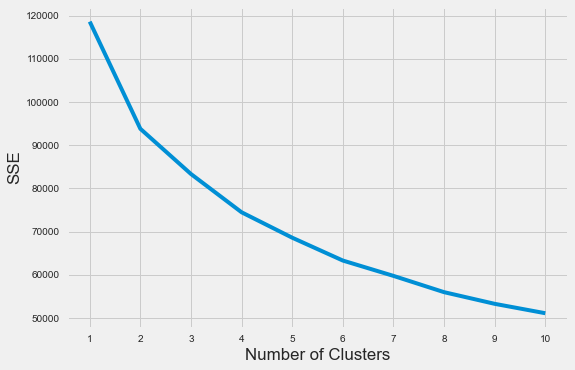

In [21]:
# elbow method 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [22]:
# fit the data
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_std)

In [23]:
# get labels 
kmeans.labels_

array([3, 3, 1, ..., 3, 0, 3], dtype=int32)

In [24]:
# assign labels to the original data
X['label'] = kmeans.labels_
X['label'].value_counts()

1    4552
2    4098
3    3399
0    2776
Name: label, dtype: int64

In [25]:
# get cluster information 
cluster = X.groupby('label').mean()
cluster['count'] = X['label'].value_counts()

cluster

,gender,income,duration,offer received,offer viewed,offer completed,transaction,value,count
label,,,,,,,,,
0,0.184798,51013.328530,1025.573127,4.362392,3.167867,2.109150,14.006484,94.106084,2776
1,0.177285,54202.328647,204.150923,4.515817,3.165861,0.816344,4.982206,31.544539,4552
2,0.540752,73086.627623,570.629331,5.210102,4.415813,3.927770,10.552709,228.165041,4098
3,0.762871,82900.264784,479.854663,3.672845,2.518094,1.993822,5.634304,116.237961,3399


**Construct outcome variables**

In [26]:
# put labels into the original data to join with outcome variables (on user id)
df_input['label'] = kmeans.labels_
df = df_input[['id', 'label']]

# merge to get the target users
output_df = pd.merge(df, transcript_offer_completion, how='left', left_on='id', right_on='person').drop(columns=['id', 'person'])

# get the outcome information 
outcome = output_df.groupby('label').mean()

outcome

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
label,,,,,,,,,,
0,0.434576,0.905561,0.615288,0.0,0.319295,0.0,0.629288,0.382091,0.681615,0.922329
1,0.118622,0.356467,0.219728,0.0,0.135300,0.0,0.289619,0.159794,0.263972,0.342593
2,0.876681,0.950790,0.899853,0.0,0.853098,0.0,0.909957,0.888146,0.893685,0.976052
3,0.609085,0.787322,0.663426,0.0,0.657162,0.0,0.703116,0.718579,0.690014,0.817949
